# Deep Learning with PyTorch : Build a Generative Adversarial Network

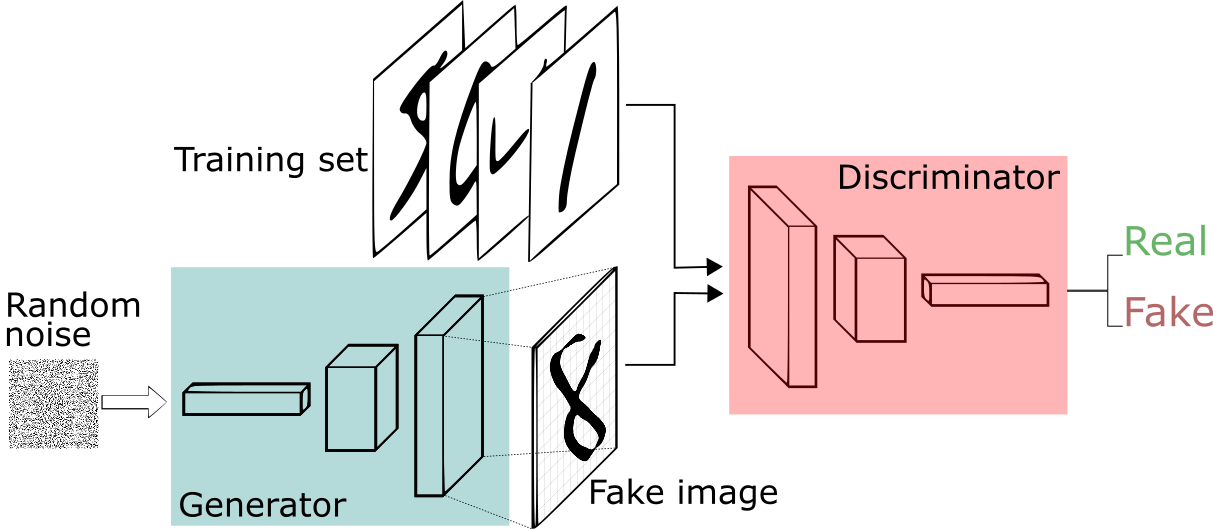

In [90]:
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [91]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

batch_size = 128
noise_dim = 64 # used for generator model

# Optimizer's parameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 50

cuda


# Load MNIST Dataset

In [92]:
from torchvision import datasets, transforms as T

In [93]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor()
])

In [94]:
trainset = datasets.MNIST(root='MNIST/',
                          download=True,
                          train=True,
                          transform=train_augs)
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

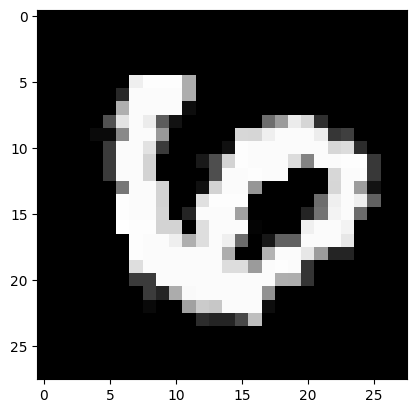

In [95]:
image, label = trainset[9000]

plt.imshow(image.squeeze(), cmap='gray')

In [96]:
print(f'Total images present in trainset are: {len(trainset)}')

Total images present in trainset are: 60000


# Load Dataset Into Batches

In [97]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [98]:
trainloader = DataLoader(dataset=trainset,
                         batch_size=batch_size,
                         shuffle=True)
trainloader

In [99]:
print(f'Total number of batches in trainloader: {len(trainloader)}')

Total number of batches in trainloader: 469


In [100]:
dataiter = next(iter(trainloader))
images, _ = dataiter
print(images.shape)

torch.Size([128, 1, 28, 28])


In [101]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

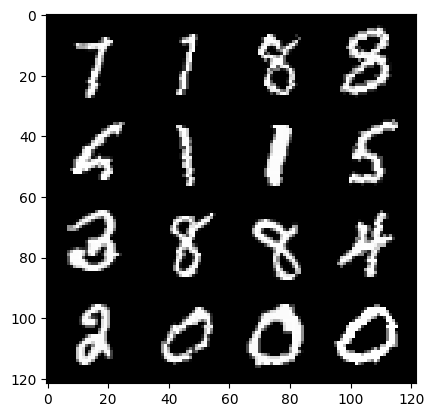

In [102]:
show_tensor_images(images, num_images=16)

# Create Discriminator Network

In [103]:
#In case if torch summary is not installed

!pip install torchsummary

Discriminator Network is just a binary classifier: Real image or Fake image.

In [104]:
from torch import nn
from torchsummary import summary

**Model architecture for Discriminator**

```
input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)
```

In [106]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
      nn.Conv2d(in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
    )

In [107]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1 = get_disc_block(in_channels=1,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=2)
        self.block_2 = get_disc_block(in_channels=16,
                                      out_channels=32,
                                      kernel_size=(5, 5),
                                      stride=2)
        self.block_3 = get_disc_block(in_channels=32,
                                      out_channels=64,
                                      kernel_size=(5, 5),
                                      stride=2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)

    def forward(self, images):
        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)

        x4 = self.flatten(x3)
        x5 = self.linear(x4)

        return x5

In [108]:
D = Discriminator()
D.to(device)

summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

**Model architecture for Generator**

```
z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)
```

In [110]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
    if final_block == True:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel_size,
                               stride=stride),
            nn.Tanh()
        )

    return nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=kernel_size,
                         stride=stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [111]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(in_channels=noise_dim,
                                     out_channels=256,
                                     kernel_size=(3, 3),
                                     stride=2)
        self.block_2 = get_gen_block(in_channels=256,
                                     out_channels=128,
                                     kernel_size=(4, 4),
                                     stride=1)
        self.block_3 = get_gen_block(in_channels=128,
                                     out_channels=64,
                                     kernel_size=(3, 3),
                                     stride=2)

        self.block_4 = get_gen_block(in_channels=64,
                                     out_channels=1,
                                     kernel_size=(4, 4),
                                     stride=2,
                                     final_block=True)

    def forward(self, r_noise_vec):
        # (bs, noise_dim) -> (bs, noise_dim, 1, 1)
        x = r_noise_vec.view(-1, self.noise_dim, 1, 1)

        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)

        return x4

In [112]:
G = Generator(noise_dim=noise_dim)
G.to(device)

summary(G, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [113]:
# Replace Random initialized weights to Normal weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [114]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [115]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

In [116]:
D_opt = torch.optim.Adam(params=D.parameters(),
                        lr=lr,
                        betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(params=G.parameters(),
                        lr=lr,
                        betas=(beta_1, beta_2))

# Training Loop

In [117]:
for epoch in range(epochs):
    total_d_loss, total_g_loss = 0, 0

    for real_img, _ in tqdm(trainloader):
        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dim, device=device)

        # Find loss and update weights for D (train D)
        D_opt.zero_grad()

        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)

        D_loss = (D_fake_loss + D_real_loss) / 2
        total_d_loss += D_loss.item()

        D_loss.backward()
        D_opt.step()

        # Find loss and update weights for G (train G)
        G_opt.zero_grad()

        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)
        total_g_loss += G_loss.item()

        G_loss.backward()
        G_opt.step()

    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)

    print(f'Epoch: {epoch} | D_loss: {avg_d_loss:.4f} | G_loss: {avg_g_loss:.4f}')

#     show_tensor_images(fake_img)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 0 | D_loss: 0.6857 | G_loss: 0.6895


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 | D_loss: 0.6800 | G_loss: 0.7092


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | D_loss: 0.6468 | G_loss: 0.7457


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | D_loss: 0.6173 | G_loss: 0.7850


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | D_loss: 0.5988 | G_loss: 0.8189


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | D_loss: 0.5957 | G_loss: 0.8374


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | D_loss: 0.6016 | G_loss: 0.8438


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | D_loss: 0.6096 | G_loss: 0.8411


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | D_loss: 0.6170 | G_loss: 0.8405


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | D_loss: 0.6219 | G_loss: 0.8349


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | D_loss: 0.6260 | G_loss: 0.8343


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | D_loss: 0.6302 | G_loss: 0.8290


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | D_loss: 0.6319 | G_loss: 0.8298


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | D_loss: 0.6321 | G_loss: 0.8312


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | D_loss: 0.6364 | G_loss: 0.8275


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | D_loss: 0.6367 | G_loss: 0.8285


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | D_loss: 0.6379 | G_loss: 0.8247


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 | D_loss: 0.6383 | G_loss: 0.8244


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 | D_loss: 0.6398 | G_loss: 0.8228


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 | D_loss: 0.6379 | G_loss: 0.8239


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 | D_loss: 0.6379 | G_loss: 0.8302


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 21 | D_loss: 0.6365 | G_loss: 0.8336


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 22 | D_loss: 0.6348 | G_loss: 0.8368


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 23 | D_loss: 0.6346 | G_loss: 0.8354


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 24 | D_loss: 0.6304 | G_loss: 0.8444


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 25 | D_loss: 0.6298 | G_loss: 0.8500


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 26 | D_loss: 0.6252 | G_loss: 0.8589


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 27 | D_loss: 0.6236 | G_loss: 0.8620


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 28 | D_loss: 0.6204 | G_loss: 0.8681


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 29 | D_loss: 0.6188 | G_loss: 0.8759


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 30 | D_loss: 0.6165 | G_loss: 0.8813


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 31 | D_loss: 0.6142 | G_loss: 0.8866


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 32 | D_loss: 0.6117 | G_loss: 0.8958


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 33 | D_loss: 0.6097 | G_loss: 0.9001


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 34 | D_loss: 0.6070 | G_loss: 0.9085


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 35 | D_loss: 0.6037 | G_loss: 0.9182


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 36 | D_loss: 0.6011 | G_loss: 0.9243


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 37 | D_loss: 0.5981 | G_loss: 0.9312


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 38 | D_loss: 0.5988 | G_loss: 0.9336


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 39 | D_loss: 0.5982 | G_loss: 0.9396


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 40 | D_loss: 0.5984 | G_loss: 0.9427


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 41 | D_loss: 0.5971 | G_loss: 0.9469


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 42 | D_loss: 0.5978 | G_loss: 0.9500


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 43 | D_loss: 0.5979 | G_loss: 0.9490


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 44 | D_loss: 0.5977 | G_loss: 0.9523


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 45 | D_loss: 0.5979 | G_loss: 0.9502


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 46 | D_loss: 0.5965 | G_loss: 0.9485


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 47 | D_loss: 0.5989 | G_loss: 0.9502


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 48 | D_loss: 0.5966 | G_loss: 0.9567


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 49 | D_loss: 0.5976 | G_loss: 0.9593


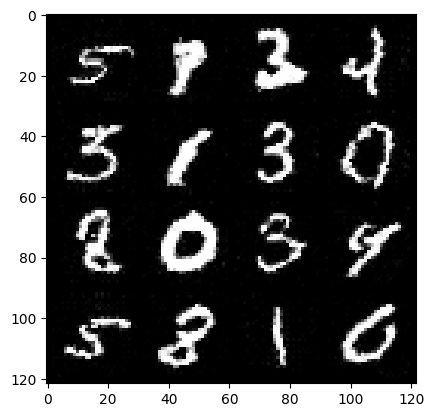

In [118]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device=device)
generated_image = G(noise)

show_tensor_images(generated_image)